# Games Success Metrics

In this project we will try to identify patterns that determine whether a game succeeds or not.  
This will allow us to spot potential big winners and plan advertising campaigns.  
The data going back to 2016 and it contains the abbreviation ESRB.  
The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.

## 1. Importing libraries and reading data files

In [1]:
# Importing libraries
import seaborn as sns
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from scipy import stats as st
from IPython.display import Markdown, display
from functools import reduce

In [2]:
# Importing sidetable
import sys
!{sys.executable} -m pip install sidetable
import sidetable

In [3]:
# reading datasets and storing them into variables
try:
    data = pd.read_csv('datasets/games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')


In [4]:
#Checking the Data
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


We already see that we have some missing values in the dataset and the columns names are not lower case. we will fix that.

## 2. Data Preparation

In [5]:
# Making the columns names lower case
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Next we will see how many missing values we have and their percentages:**

In [7]:
# Checking the missing values
null_stat = data.isnull().sum().to_frame('count')
null_stat['%'] = round(((null_stat['count']) / len(data))*100,2)
null_stat

,count,%
name,2,0.01
platform,0,0.00
year_of_release,269,1.61
genre,2,0.01
na_sales,0,0.00
eu_sales,0,0.00
jp_sales,0,0.00
other_sales,0,0.00
critic_score,8578,51.32
user_score,6701,40.09


In [8]:
data[data.name.isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


We will drop these rows, since we can't restore them anyway.

In [9]:
#Droping the missing values in the name columns
data = data[data.name.notna()]

In [10]:
# Restoration of values in year of release:
year_null = data[data.year_of_release.isnull()]
year_null.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


We can see that some of the games has the year included in the name. we can use that information to restore the data.  
Also, we will check the year of release for the same game on other platforms.

In [11]:
# Getting year of release out of the name of the game:
counter = 0
for row in data[data.year_of_release.isnull()].itertuples():
    numlist = [int(s) for s in row.name.split() if s.isdigit()]
    for num in numlist:
        if 1997 < num < 2016:
            data.loc[data.name == row.name,'year_of_release'] = num
            counter += 1
print('Values restores:',counter)            
data.stb.missing(style=True)

Values restores: 15


,missing,total,percent
critic_score,"8,576","16,713",51.31%
rating,"6,764","16,713",40.47%
user_score,"6,699","16,713",40.08%
year_of_release,254,"16,713",1.52%
name,0,"16,713",0.00%
platform,0,"16,713",0.00%
genre,0,"16,713",0.00%
na_sales,0,"16,713",0.00%
eu_sales,0,"16,713",0.00%
jp_sales,0,"16,713",0.00%


Great! we have managed to restore some of the missing values in year of release.  
Now we will create a dictionary of all the games and the name of releases from all the plaform.


In [12]:
#Creating a dictionary:
dictionary = dict(zip(data[data.name.notna()].name, (data[data.year_of_release.notna()].year_of_release)))

#Restoring the year of release:
counter = 0 
for row in data[data.year_of_release.isnull()].itertuples():
    data.loc[row.Index,'year_of_release'] = dictionary[row.name]
    counter +=1
#Check the results:
print('Values restored:',counter)
data.stb.missing(style=True)

Values restored: 254


,missing,total,percent
critic_score,"8,576","16,713",51.31%
rating,"6,764","16,713",40.47%
user_score,"6,699","16,713",40.08%
name,0,"16,713",0.00%
platform,0,"16,713",0.00%
year_of_release,0,"16,713",0.00%
genre,0,"16,713",0.00%
na_sales,0,"16,713",0.00%
eu_sales,0,"16,713",0.00%
jp_sales,0,"16,713",0.00%


Amazing!
We managed to restore all the missing values based on information from other platforms.  

We have many missing values in the score and rating columns. let's try to look for any dependencies between them

In [13]:
# Checking for missing values dependencies
null_data = data[(data.critic_score.isnull()) & (data.user_score.isnull()) & (data.rating.isnull())]
null_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


There are 6619 rows sharing missing values in the scroe and rating columns, but we can't find anything that relates them all. we will leave them as is for now, since it's a big part of the dataset.  

Reasons for missing values in score and rating:
- The game is too old
- The game is still new
- The game was not sold


In [14]:
# Calculate the total sales for each game from all the regions:
df = data.copy()
df['total_sales'] = df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [15]:
df.describe(include=['object'])

,name,platform,genre,user_score,rating
count,16713,16713,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


**user score column should be numeric, but it's an object becuase there is "tbd" values. let's see how much of these we have**

In [16]:
#Check how much "tbd" score we have in the data set:
print('We have {} "tbd" scores'.format(df[df.user_score == 'tbd'].user_score.count()))

We have 2424 "tbd" scores


This is a lot of data, we will keep it this way and we will deal with those locally in the analysis if needed.

## 3. Data Analysis

In order to determine what makes a game succesfull we will make some analysis.  
First we will look at how many games were released in different years

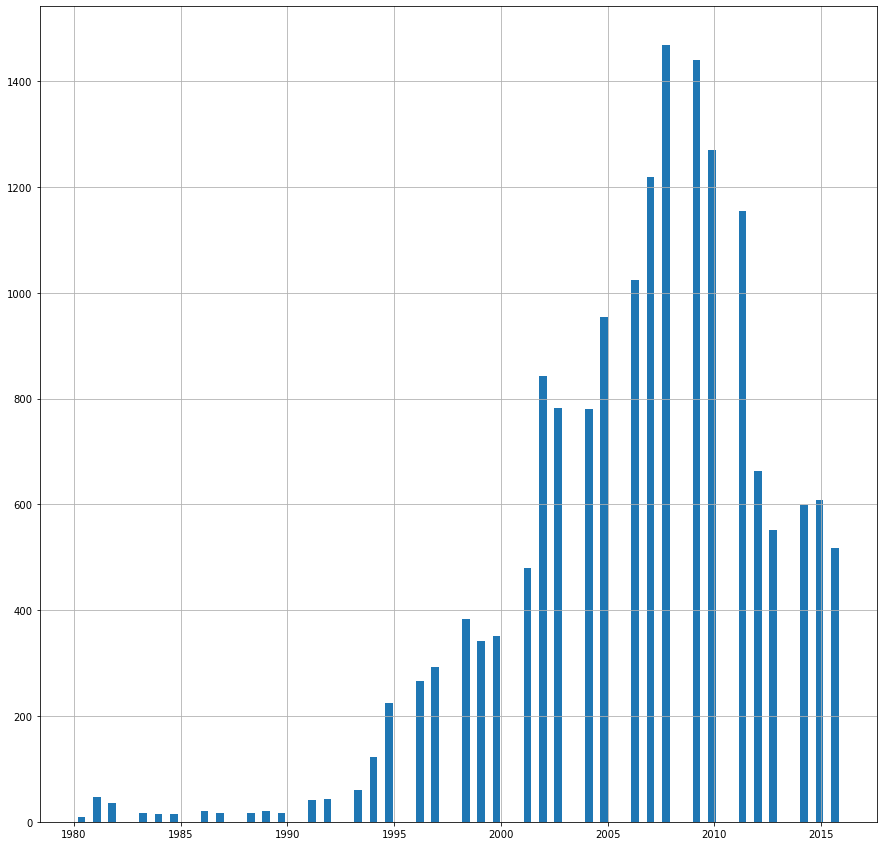

In [17]:
# Plotting histogram for game releases
df.year_of_release.hist(bins=50, rwidth=0.5, figsize=(15,15))
plt.show()

**Update:**
We can see that in the early years we had little game release, and this data might not be relevant for future prognosis. since Some of these platforms do not exist anymore.
We will look at the data starting from year 2003.

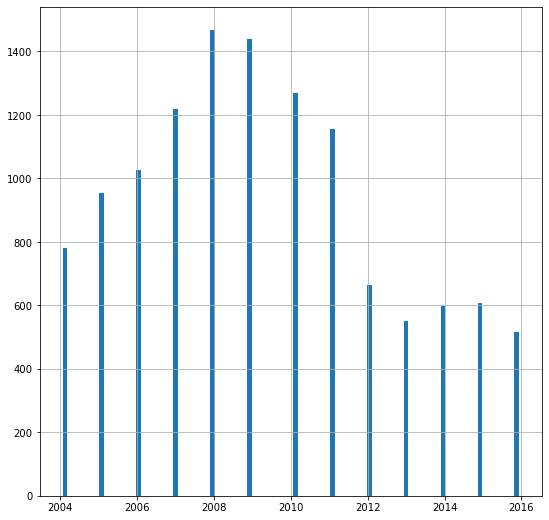

In [51]:
# Filtering data from year 2003 and later
df = df[df.year_of_release > 2003]
df.year_of_release.hist(bins=50, rwidth=0.5, figsize=(9,9))
plt.show()

Next we will look at how sales varied from platform to platform:

In [19]:
platform_pvt = pd.pivot_table(df, values = 'total_sales', index='platform', aggfunc ='sum').sort_values(by='total_sales', ascending = False).reset_index()
platform_pvt

,platform,total_sales
0,X360,967.25
1,PS3,937.65
2,Wii,902.14
3,DS,805.70
4,PS2,656.15
5,PS4,314.14
6,PSP,293.78
7,3DS,258.54
8,PC,181.27
9,XOne,159.32


We will use the Z-Score method to determine which are the top platform

In [20]:
platform_pvt['sales_z']=(platform_pvt['total_sales']-platform_pvt['total_sales'].mean())/platform_pvt['total_sales'].std()
platform_pvt['color']=['black' if x<0 else 'green' for x in platform_pvt['sales_z']]
platform_pvt

,platform,total_sales,sales_z,color
0,X360,967.25,1.869685,green
1,PS3,937.65,1.785100,green
2,Wii,902.14,1.683627,green
3,DS,805.70,1.408042,green
4,PS2,656.15,0.980689,green
5,PS4,314.14,0.003366,green
6,PSP,293.78,-0.054815,black
7,3DS,258.54,-0.155516,black
8,PC,181.27,-0.376322,black
9,XOne,159.32,-0.439046,black


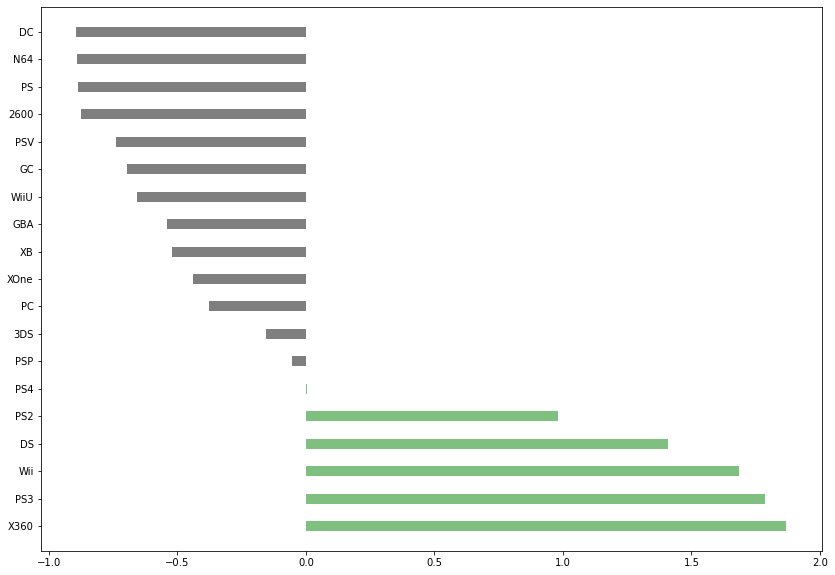

In [21]:
plt.figure(figsize=(14,10))
plt.hlines(y=platform_pvt.platform,xmax=platform_pvt.sales_z, xmin=0,color=platform_pvt.color, alpha=0.5, linewidth=10)
plt.show()

In [22]:
# Creating a list with top 6 platforms:
top_platform = platform_pvt[platform_pvt.color == 'green'].platform.reset_index(drop=True)
top_platform

0    X360
1     PS3
2     Wii
3      DS
4     PS2
5     PS4
Name: platform, dtype: object

**The list above represent all the platforms that has positive Z score**  

Next, we will find what is the life span of platforms using lineplot

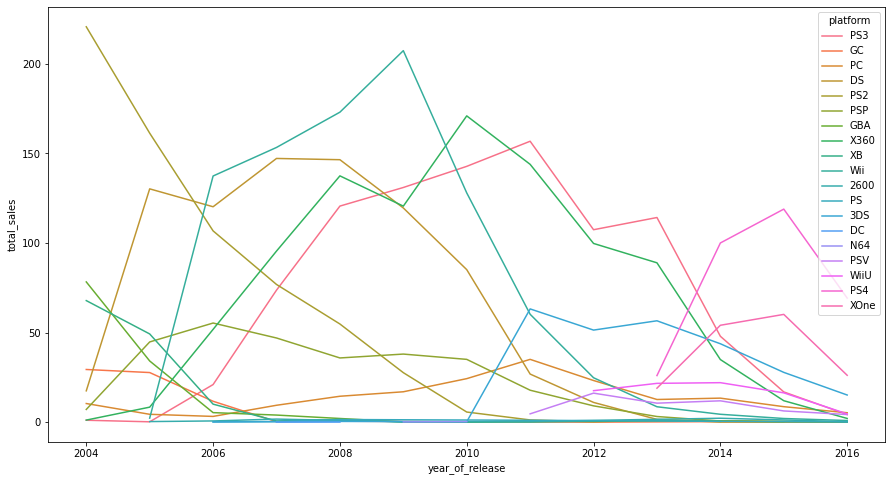

In [23]:
grp = df.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index().sort_values(by='year_of_release')

plt.figure(figsize=(15,8))
ax = sns.lineplot(data=grp, x="year_of_release", y="total_sales",hue="platform")

Well, this is not so clear but we can see that old platforms has longer life span because lack of competition.  We will create a list of platform ago in order to make things more clear.

In [24]:
# Finding the minimum an maximum year of release for each platform:
min_max = df.groupby('platform')['year_of_release'].agg(['min','max']).reset_index()

# Calculating plaform age:
min_max['age'] = min_max['max'] - min_max['min']

# Sorting values by max:
min_max.sort_values(by='max', ascending = False).reset_index(drop=True)

,platform,min,max,age
0,2600,2005.0,2016.0,11.0
1,3DS,2006.0,2016.0,10.0
2,X360,2004.0,2016.0,12.0
3,WiiU,2012.0,2016.0,4.0
4,Wii,2005.0,2016.0,11.0
5,PSV,2011.0,2016.0,5.0
6,PS4,2013.0,2016.0,3.0
7,PS3,2004.0,2016.0,12.0
8,PS2,2004.0,2016.0,12.0
9,PS,2006.0,2016.0,10.0


Some platforms exist since 1985 like PC, and some of them are long gone like GB.  
we will create a list of the relevant platforms

In [25]:
# Relevant platforms for prognosis:
rel_platform = min_max[min_max['max'] > 2013]
rel_platform

,platform,min,max,age
0,2600,2005.0,2016.0,11.0
1,3DS,2006.0,2016.0,10.0
3,DS,2004.0,2016.0,12.0
4,GBA,2004.0,2016.0,12.0
5,GC,2004.0,2016.0,12.0
7,PC,2004.0,2016.0,12.0
8,PS,2006.0,2016.0,10.0
9,PS2,2004.0,2016.0,12.0
10,PS3,2004.0,2016.0,12.0
11,PS4,2013.0,2016.0,3.0


In [26]:
# Finding median age for a platform:
min_max['age'].median()

11.0

**Update:**
According to the plots and tables above, we found out that it takes old plaform approximately 10 years for a platform to fade.  
And the new platforms appeared at around 2013. It will be wise to check the recenet years in order to make our prognosis.

With that said, in order to build a prognosis for 2017, we will look at data for the last 3 years.

In [27]:
# Creating data for the chosen period:
year = 2012
# Relevant data:
rel_data = df.query('year_of_release >= @year').reset_index(drop=True)
rel_data.info()
rel_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2939 entries, 0 to 2938
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2939 non-null   object 
 1   platform         2939 non-null   object 
 2   year_of_release  2939 non-null   float64
 3   genre            2939 non-null   object 
 4   na_sales         2939 non-null   float64
 5   eu_sales         2939 non-null   float64
 6   jp_sales         2939 non-null   float64
 7   other_sales      2939 non-null   float64
 8   critic_score     1345 non-null   float64
 9   user_score       1700 non-null   object 
 10  rating           1649 non-null   object 
 11  total_sales      2939 non-null   float64
dtypes: float64(7), object(5)
memory usage: 275.7+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013.0,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Call of Duty: Black Ops II,PS3,2012.0,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [28]:
# Creating pivot table with top platform in our sample:
pvt = pd.pivot_table(rel_data, values = 'total_sales', columns='platform', index='year_of_release', aggfunc ='sum', fill_value=0)
pvt

platform,2600,3DS,DS,GBA,GC,PC,PS,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,
2012.0,0.98,51.38,11.01,0.00,0.01,23.24,0.00,0.18,107.40,0.00,9.09,16.19,24.78,17.56,99.74,0.00,0.00
2013.0,0.00,56.57,1.54,0.00,0.00,12.64,0.00,1.12,114.21,25.99,3.14,10.59,8.59,21.65,88.93,0.91,18.96
2014.0,2.18,43.76,0.04,0.67,0.29,13.40,0.00,0.00,47.93,100.00,0.61,11.90,4.39,22.03,34.93,0.43,54.07
2015.0,0.00,27.78,0.00,0.00,0.00,8.63,0.00,0.00,16.87,118.90,0.12,6.25,2.03,16.35,11.96,0.00,60.14
2016.0,0.27,15.14,0.04,0.03,0.01,5.25,0.09,0.02,4.23,69.25,0.00,4.25,0.90,4.60,2.06,0.00,26.15


To check which platforms are growing and which ones are shrinking, we will need to calculate the performance of each platform in relation to its previous year.
We will use the shift method to do that, and then create a heat map to visualize

In [29]:
# Creating a df representing the difference in total sales between the years
heat_df = (pvt - pvt.shift(+1)).T
heat_df

year_of_release,2012.0,2013.0,2014.0,2015.0,2016.0
platform,,,,,
2600,NaN,-0.98,2.18,-2.18,0.27
3DS,NaN,5.19,-12.81,-15.98,-12.64
DS,NaN,-9.47,-1.50,-0.04,0.04
GBA,NaN,0.00,0.67,-0.67,0.03
GC,NaN,-0.01,0.29,-0.29,0.01
PC,NaN,-10.60,0.76,-4.77,-3.38
PS,NaN,0.00,0.00,0.00,0.09
PS2,NaN,0.94,-1.12,0.00,0.02
PS3,NaN,6.81,-66.28,-31.06,-12.64


According to the table we can see that PS2 started to shrink at 2005 while PS3 started to grow since that year which is making a lot of sense.  
We will creat a heat map to visualize the table above.

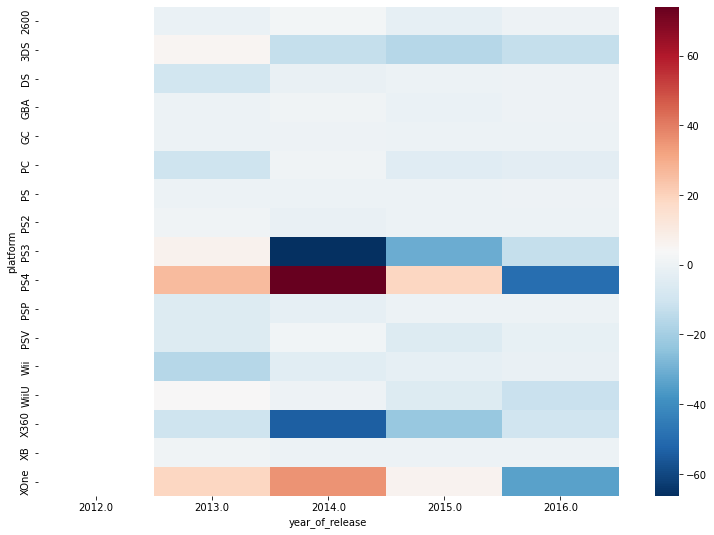

In [30]:
# Plotting the heatmap:
plt.figure(figsize=(13,9))
ax = sns.heatmap(heat_df, cmap='RdBu_r')

From the tables and the heatmap above we can see that:
1. All of the platforms are showing shrinkage at 2016, but this is due to the fact that we dont have a complate data for this year.
2. Newer versions of PS platform (PS4) is growing while older ones (PS2,PS3) are shrinking. Same goes with XBOX

In [31]:
grp=rel_data.groupby(['platform','name'])['total_sales'].sum().reset_index()
grp

,platform,name,total_sales
0,2600,Adventure,1.30
1,2600,Air-Sea Battle,0.98
2,2600,Indy 500,0.27
3,2600,Maze Craze: A Game of Cops 'n Robbers,0.44
4,2600,Super Breakout,0.44
...,...,...,...
2933,XOne,XCOM 2,0.04
2934,XOne,ZombiU,0.01
2935,XOne,Zombie Army Trilogy,0.11
2936,XOne,Zoo Tycoon (2013),0.36


In [32]:
order=grp.groupby(['platform'])['total_sales'].sum().reset_index().sort_values(by='total_sales')['platform']
order

6       PS
4       GC
3      GBA
7      PS2
15      XB
0     2600
2       DS
10     PSP
12     Wii
11     PSV
5       PC
13    WiiU
16    XOne
1      3DS
14    X360
8      PS3
9      PS4
Name: platform, dtype: object

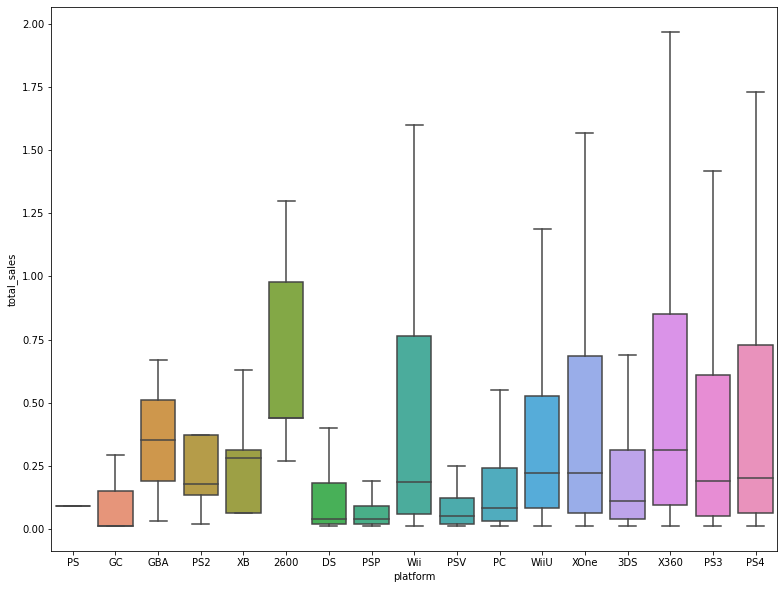

In [33]:
plt.figure(figsize=(13,10))
sns.boxplot(x='platform',y='total_sales',data=grp,order=order,showfliers = False)
plt.show()

In [34]:
grp.groupby('platform').describe().T

platform               2600         3DS         DS       GBA        GC  \
total_sales count  5.000000  397.000000  33.000000  2.000000  3.000000   
            mean   0.686000    0.490252   0.382727  0.350000  0.103333   
            std    0.435178    1.385611   1.396344  0.452548  0.161658   
            min    0.270000    0.010000   0.010000  0.030000  0.010000   
            25%    0.440000    0.040000   0.020000  0.190000  0.010000   
            50%    0.440000    0.110000   0.040000  0.350000  0.010000   
            75%    0.980000    0.310000   0.180000  0.510000  0.150000   
            max    1.300000   14.600000   8.060000  0.670000  0.290000   

platform                   PC    PS       PS2        PS3         PS4  \
total_sales count  256.000000  1.00  4.000000  500.00000  392.000000   
            mean     0.246719  0.09  0.330000    0.58128    0.801378   
            std      0.489590   NaN  0.419762    1.45353    1.609456   
            min      0.010000  0.09  0.020000    0.01000    0.010000   
            25%      0.030000  0.09  0.132500    0.05000    0.060000   
            50%      0.080000  0.09  0.175000    0.19000    0.200000   
            75%      0.240000  0.09  0.372500    0.61000    0.730000   
            max      5.140000  0.09  0.950000   21.05000   14.630000   

platform                  PSP         PSV        Wii        WiiU        X360  \
total_sales count  176.000000  411.000000  60.000000  147.000000  299.000000   
            mean     0.073636    0.119659   0.678167    0.559116    0.794716   
            std      0.117922    0.203011   1.154271    1.058836    1.694932   
            min      0.010000    0.010000   0.010000    0.010000    0.010000   
            25%      0.020000    0.020000   0.057500    0.080000    0.095000   
            50%      0.040000    0.050000   0.185000    0.220000    0.310000   
            75%      0.090000    0.120000   0.762500    0.525000    0.850000   
            max      1.280000    1.960000   6.760000    7.090000   16.270000   

platform                 XB        XOne  
total_sales count  5.000000  247.000000  
            mean   0.268000    0.645020  
            std    0.234243    1.036139  
            min    0.060000    0.010000  
            25%    0.060000    0.060000  
            50%    0.280000    0.220000  
            75%    0.310000    0.685000  
            max    0.630000    7.390000

**According to the boxplot and the describe table abobe we can see that:**
1. Means in total sales are quite similar within the same platforms, for example XBOX360 and XBOX-ONE
2. All medians are between 0 and 0.5
3. As expected, in those years some platforms sold more than others
4. We have platforms with big variance while others with smaller one
5. Leading platforms (PS3, PS4, X360) have similar variance

Let's have a look at the PS4 platform and check how user and professional reviews affect sales. We will use a scatterplot in order to do that

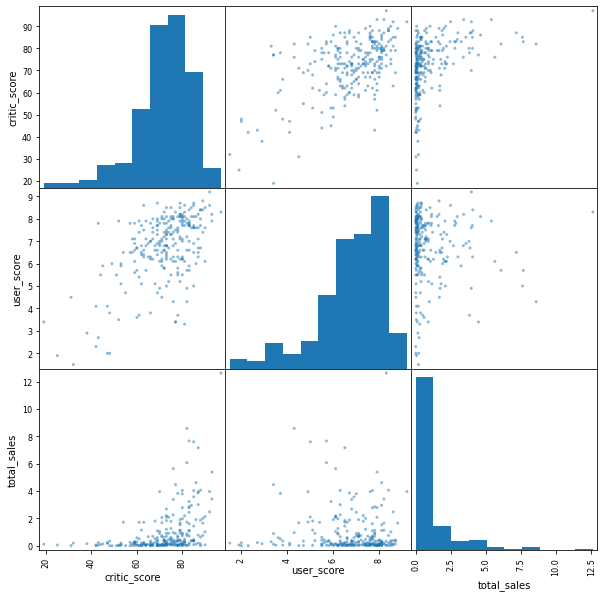

In [35]:
# Filtering data for PS4 platform:
ps4_data = rel_data[rel_data.platform == 'PS4']

# Filtering for review columns:
ps4_data = ps4_data[['critic_score','user_score','total_sales']]

# Dropping NaN values:
ps4_data = ps4_data.dropna()

# Dropping "tbd" values:
ps4_data = ps4_data[ps4_data.user_score != 'tbd']

# Correcting data types:
ps4_data.user_score = ps4_data.user_score.astype('float64')

#Plotting Scatter matrix:
pd.plotting.scatter_matrix(ps4_data,figsize=(10, 10))
plt.show()

In [36]:
# Calculating corrolation:
ps4_data.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.405895
user_score,0.557654,1.000000,-0.033625
total_sales,0.405895,-0.033625,1.000000


We can see that for PS4, there is no corolation between user score, critic score and total sales.
Let's check other leading platforms. We will check the top 5.

In [37]:
# Creating the list of top leading platforms:
top5 = order.tail(5)

# Creating a function:
def score_corr(platform):
    data = rel_data[rel_data.platform == platform]
    data = data[['critic_score','user_score','total_sales']]
    data = data.dropna()
    data = data[data.user_score != 'tbd']
    data.user_score = data.user_score.astype('float64')
    pd.plotting.scatter_matrix(data,figsize=(10, 10))
    plt.show()
    return data

This is the scatter plot and the corrolation table of: XOne


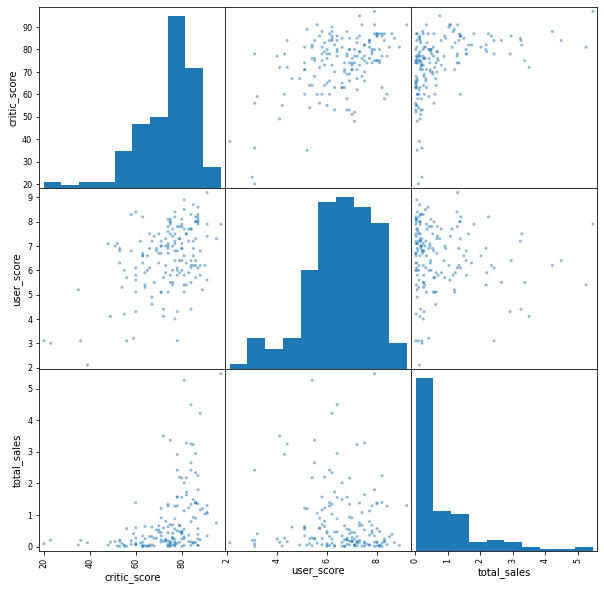

              critic_score  user_score  total_sales
critic_score      1.000000    0.472462     0.410422
user_score        0.472462    1.000000    -0.094003
total_sales       0.410422   -0.094003     1.000000

No corrolation between critic score and total sales
No corrolation between user score and total sales

This is the scatter plot and the corrolation table of: 3DS


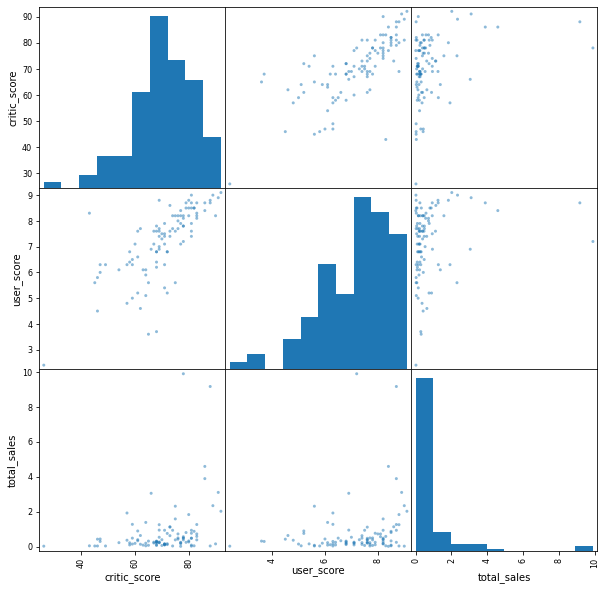

              critic_score  user_score  total_sales
critic_score      1.000000    0.722762     0.310553
user_score        0.722762    1.000000     0.201813
total_sales       0.310553    0.201813     1.000000

No corrolation between critic score and total sales
No corrolation between user score and total sales

This is the scatter plot and the corrolation table of: X360


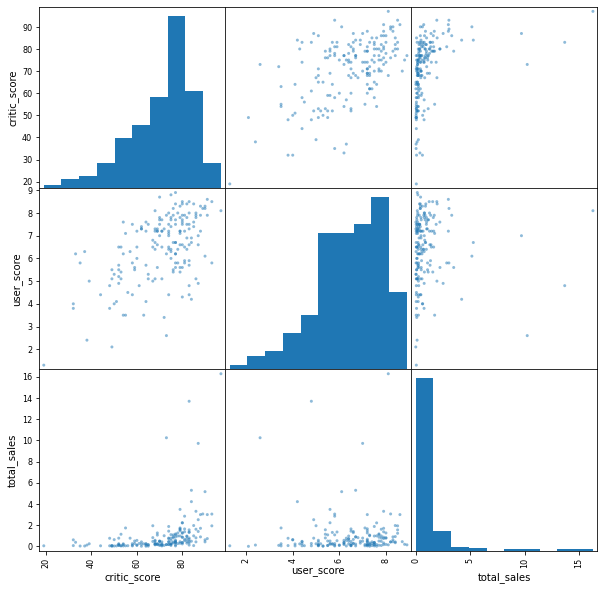

              critic_score  user_score  total_sales
critic_score      1.000000    0.552475     0.362072
user_score        0.552475    1.000000    -0.002543
total_sales       0.362072   -0.002543     1.000000

No corrolation between critic score and total sales
No corrolation between user score and total sales

This is the scatter plot and the corrolation table of: PS3


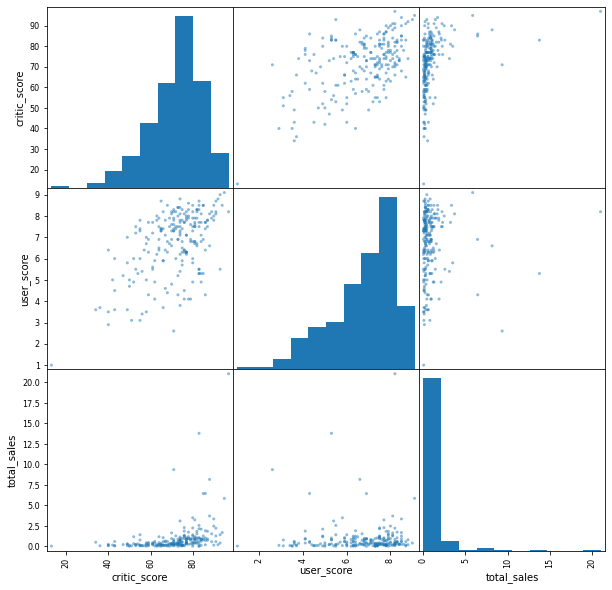

              critic_score  user_score  total_sales
critic_score      1.000000    0.532472     0.332840
user_score        0.532472    1.000000     0.000868
total_sales       0.332840    0.000868     1.000000

No corrolation between critic score and total sales
No corrolation between user score and total sales

This is the scatter plot and the corrolation table of: PS4


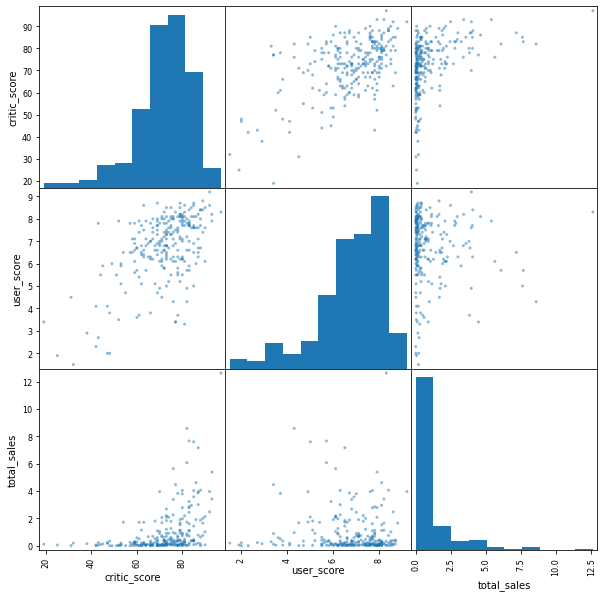

              critic_score  user_score  total_sales
critic_score      1.000000    0.557654     0.405895
user_score        0.557654    1.000000    -0.033625
total_sales       0.405895   -0.033625     1.000000

No corrolation between critic score and total sales
No corrolation between user score and total sales



In [38]:
# Looping between top platform:
for platform in top5:
    print('This is the scatter plot and the corrolation table of:',platform)
    plot = score_corr(platform)
    result = plot.corr()
    print(result)
    print()
    print('No corrolation between critic score and total sales' if result.critic_score.total_sales <0.7 else 'There is corrolation between critic score and total sales')
    print('No corrolation between user score and total sales' if result.user_score.total_sales <0.7 else 'There is corrolation between user score and total sales')
    print()

**According to the plots and the corrolation tables, there is corrolation between user and critic score and the total sales.**

## 4. Create a user profile for each region

In this section we will create a uer profile for each region to determine:
1. The top five platforms. We will describe variations in their market shares from region to region.
2. The top five genres. We will explain the difference between them
3. Check if ESRB ratings affect sales in individual region

In [39]:
rel_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013.0,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Call of Duty: Black Ops II,PS3,2012.0,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [40]:
# Creating list of genres and regions:
regions = {'North America':'na_sales','Europe':'eu_sales','Japan':'jp_sales','Others':'other_sales'}

# Creating a function for aggregating data into a pivot table:
def top5_pvt(data,region,index):
    result = (
        pd.pivot_table(
        data=data, 
        index=index, 
        values=region, 
        aggfunc=('sum','mean'))
    .sort_values(by='sum', ascending=False)
    .head()
    .reset_index()
    )
    return result

In [41]:
# Creating data frames for top 5 platform for each region
for region in regions:
    display(top5_pvt(rel_data,regions[region],'platform'))
    display(Markdown('^ **Top 5 platforms for {}** ^'.format(region)))

,platform,mean,sum
0,X360,0.470736,140.75
1,PS4,0.277398,108.74
2,PS3,0.207725,104.07
3,XOne,0.377004,93.12
4,3DS,0.139320,55.31


^ **Top 5 platforms for North America** ^

,platform,mean,sum
0,PS4,0.359923,141.09
1,PS3,0.213932,107.18
2,X360,0.250167,74.80
3,XOne,0.208866,51.59
4,3DS,0.107406,42.64


^ **Top 5 platforms for Europe** ^

,platform,mean,sum
0,3DS,0.221184,87.81
1,PS3,0.071796,35.97
2,PSV,0.051192,21.04
3,PS4,0.040714,15.96
4,WiiU,0.088503,13.01


^ **Top 5 platforms for Japan** ^

,platform,mean,sum
0,PS4,0.123342,48.35
1,PS3,0.086667,43.42
2,X360,0.068528,20.49
3,XOne,0.057773,14.27
4,3DS,0.022343,8.87


^ **Top 5 platforms for Others** ^

We will now merge the tables in order to compare them

In [42]:
# Creating new tables for merging
na_sales = top5_pvt(rel_data,'na_sales','platform').rename(columns={"mean": "na_mean", "sum": "na_sum"})
eu_sales = top5_pvt(rel_data,'eu_sales','platform').rename(columns={"mean": "eu_mean", "sum": "eu_sum"})
jp_sales = top5_pvt(rel_data,'jp_sales','platform').rename(columns={"mean": "jp_mean", "sum": "jp_sum"})
other_sales = top5_pvt(rel_data,'other_sales','platform').rename(columns={"mean": "other_mean", "sum": "other_sum"})

# Merging the tables:
data_frames = [na_sales, eu_sales, jp_sales,other_sales]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['platform'], how='outer'), data_frames)
df_merged.fillna('not in top 5')

,platform,na_mean,na_sum,eu_mean,eu_sum,jp_mean,jp_sum,other_mean,other_sum
0,X360,0.470736,140.75,0.250167,74.8,not in top 5,not in top 5,0.068528,20.49
1,PS4,0.277398,108.74,0.359923,141.09,0.040714,15.96,0.123342,48.35
2,PS3,0.207725,104.07,0.213932,107.18,0.071796,35.97,0.086667,43.42
3,XOne,0.377004,93.12,0.208866,51.59,not in top 5,not in top 5,0.057773,14.27
4,3DS,0.13932,55.31,0.107406,42.64,0.221184,87.81,0.022343,8.87
5,PSV,not in top 5,not in top 5,not in top 5,not in top 5,0.051192,21.04,not in top 5,not in top 5
6,WiiU,not in top 5,not in top 5,not in top 5,not in top 5,0.088503,13.01,not in top 5,not in top 5


**What we can learn from this is:**
1. PS3, PS4 and 3DS made it to the top five in all the markets
2. PSV and WiiU are popular in Japan
3. X360 and XOne make almost double the revenue in North America than in Europe
4. PS3 makes almost the same revenue in North America and Europe althouth the average price in North America is slightly higher

In [43]:
# Creating data frames for top 5 genres for each region
for region in regions:
    display(top5_pvt(rel_data,regions[region],'genre'))
    display(Markdown('^ **Top 5 genres for {}** ^'.format(region)))

,genre,mean,sum
0,Action,0.174661,182.87
1,Shooter,0.604174,146.21
2,Sports,0.301971,82.74
3,Role-Playing,0.171635,64.02
4,Misc,0.195126,38.83


^ **Top 5 genres for North America** ^

,genre,mean,sum
0,Action,0.154919,162.20
1,Shooter,0.470579,113.88
2,Sports,0.252409,69.16
3,Role-Playing,0.130134,48.54
4,Racing,0.227833,27.34


^ **Top 5 genres for Europe** ^

,genre,mean,sum
0,Role-Playing,0.175576,65.49
1,Action,0.051070,53.47
2,Misc,0.068543,13.64
3,Simulation,0.126951,10.41
4,Fighting,0.086577,9.61


^ **Top 5 genres for Japan** ^

,genre,mean,sum
0,Action,0.049771,52.11
1,Shooter,0.154256,37.33
2,Sports,0.082226,22.53
3,Role-Playing,0.039759,14.83
4,Misc,0.039296,7.82


^ **Top 5 genres for Others** ^

We can see that apart of Japan, everywhere in the world the most 3 popular genres are the same:
1. Action
2. Shooter
3. Sports

In Japan, Role-Playing is leading followed by action and misc.

**Next we will check how ESRB ratings affect sales in individual region**

In [44]:
# Creating data frames for top ratings for each region
for region in regions:
    display(top5_pvt(rel_data,regions[region],'rating'));
    display(Markdown('^ **Top 5 rating for {}** ^'.format(region)));

,rating,mean,sum
0,M,0.460356,232.48
1,E,0.287291,116.64
2,E10+,0.252219,78.44
3,T,0.157845,67.40


^ **Top 5 rating for North America** ^

,rating,mean,sum
0,M,0.385426,194.64
1,E,0.280025,113.69
2,E10+,0.184019,57.23
3,T,0.125504,53.59


^ **Top 5 rating for Europe** ^

,rating,mean,sum
0,E,0.069778,28.33
1,T,0.060937,26.02
2,M,0.043228,21.83
3,E10+,0.026334,8.19


^ **Top 5 rating for Japan** ^

,rating,mean,sum
0,M,0.125822,63.54
1,E,0.078005,31.67
2,T,0.042459,18.13
3,E10+,0.054534,16.96


^ **Top 5 rating for Others** ^

In [45]:
# Creating new tables for merging
na_sales = top5_pvt(rel_data,'na_sales','rating').rename(columns={"mean": "na_mean", "sum": "na_sum"})
eu_sales = top5_pvt(rel_data,'eu_sales','rating').rename(columns={"mean": "eu_mean", "sum": "eu_sum"})
jp_sales = top5_pvt(rel_data,'jp_sales','rating').rename(columns={"mean": "jp_mean", "sum": "jp_sum"})
other_sales = top5_pvt(rel_data,'other_sales','rating').rename(columns={"mean": "other_mean", "sum": "other_sum"})

# Merging the tables:
data_frames = [na_sales, eu_sales, jp_sales,other_sales]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['rating'], how='outer'), data_frames)
df_merged.fillna('not in top 5')

,rating,na_mean,na_sum,eu_mean,eu_sum,jp_mean,jp_sum,other_mean,other_sum
0,M,0.460356,232.48,0.385426,194.64,0.043228,21.83,0.125822,63.54
1,E,0.287291,116.64,0.280025,113.69,0.069778,28.33,0.078005,31.67
2,E10+,0.252219,78.44,0.184019,57.23,0.026334,8.19,0.054534,16.96
3,T,0.157845,67.40,0.125504,53.59,0.060937,26.02,0.042459,18.13


**We can see that the rating do affect the revenue, M rating games are leading in sales in all regions**

## Hypotheses testing

In this part of the project we will test the following hypotheses:
- **Average user ratings of the Xbox One and PC platforms are the same.**
- **Average user ratings for the Action and Sports genres are different.**

We will start with the first hypothesis:
- Average user ratings of the Xbox One and PC platforms are the same.

The **null hypothesis** $H_0$ would be: the average user ratings of the Xbox One and PC platforms are equal.


The null hypothesis was formulated this way based on the fact that the hypothesis testing checks wether or not a sample is equal (or close enough) to a value, or another sample. This is by definition.

The **alternative hypothesis** $H_1$ would be: the average user ratings of the Xbox One and PC platforms are **not** equal.

let $\alpha$ be 0.05

Assuming that $H_0$ is true, we will calculate p-value in the following code:


In [46]:
rel_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013.0,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Call of Duty: Black Ops II,PS3,2012.0,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
2934,Strawberry Nauts,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
2935,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
2936,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
2937,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


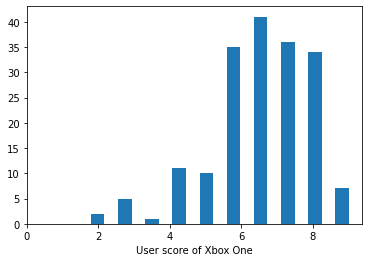

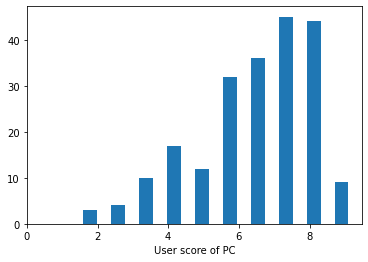

In [47]:
# Creating the samples and fixing data types:
xone = rel_data[(rel_data.platform == 'XOne') & (rel_data.user_score.notna()) & (rel_data.user_score != 'tbd')].user_score
xone = xone.astype('float64')
pc = rel_data[(rel_data.platform == 'PC') & (rel_data.user_score.notna()) & (rel_data.user_score != 'tbd')].user_score
pc = pc.astype('float64')

# Check the distribution of the samples
# xone is the sample for user score in Xbox One platform
# pc is the sample for user score in PC platform

plt.hist(xone,rwidth=0.5)
plt.xlabel('User score of Xbox One')
plt.xlim(left=0)
plt.show()
plt.hist(pc,rwidth=0.5)
plt.xlabel('User score of PC')
plt.xlim(left=0)
plt.show()

In [48]:
# Testing a hypothesis about the means of two statistical populations based on samples taken from them
# equal_var defines whether or not the variances of the samples are considered equal; default value is True
# This is one tailed distribution so p-value shall be divided by 2

alpha = 0.05
    
results = st.ttest_ind(
    xone, 
    pc,
        equal_var = st.levene(xone,pc).pvalue > 0.05)

print('p-value: ', results.pvalue / 2)

if results.pvalue / 2 < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  0.331559835943544
We can't reject the null hypothesis


p-value is greater than $\alpha$, hence we can't reject the null hypothesis.  
This means that the average user score in XBox One platform and the score in PC platform are the same.

Next, we will test the second hypothesis:
- Average user ratings for the Action and Sports genres are different.

The **null hypothesis** $H_0$ would be: the average user ratings for the Action and Sports genres are equal.


The null hypothesis was formulated this way based on the fact that the hypothesis testing checks wether or not a sample is equal (or close enough) to a value, or another sample. This is by definition.

The **alternative hypothesis** $H_1$ would be: the average user ratings for the Action and Sports genres are **not** equal.

let $\alpha$ be 0.05

Assuming that $H_0$ is true, we will calculate p-value in the following code:


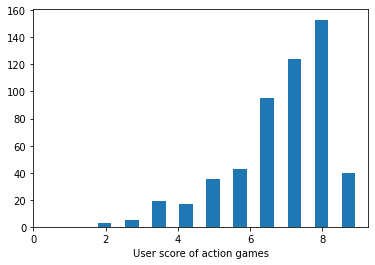

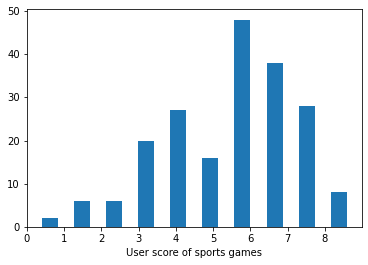

In [49]:
# Creating the samples and fixing data types:
action = rel_data[(rel_data.genre == 'Action') & (rel_data.user_score.notna()) & (rel_data.user_score != 'tbd')].user_score
action = action.astype('float64')
sports = rel_data[(rel_data.genre == 'Sports') & (rel_data.user_score.notna()) & (rel_data.user_score != 'tbd')].user_score
sports = sports.astype('float64')

# Check the distribution of the samples
# action is the sample for user score of action games
# sports is the sample for user score of sports games

plt.hist(action,rwidth=0.5)
plt.xlabel('User score of action games')
plt.xlim(left=0)
plt.show()
plt.hist(sports,rwidth=0.5)
plt.xlabel('User score of sports games')
plt.xlim(left=0)
plt.show()

In [50]:
# Testing a hypothesis about the means of two statistical populations based on samples taken from them
# equal_var defines whether or not the variances of the samples are considered equal; default value is True
# This is one tailed distribution so p-value shall be divided by 2

alpha = 0.05
    
results = st.ttest_ind(
    action, 
    sports,
        equal_var = st.levene(action,sports).pvalue > 0.05)

print('p-value: ', results.pvalue / 2)

if results.pvalue / 2 < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  2.6023093238761927e-20
We reject the null hypothesis


p-value is smaller than $\alpha$, hence we  reject the null hypothesis.  
This means that average user ratings for the Action and Sports genres are different.

## Final Conclusions

1. The gaming market is very dynamics.
2. In recent years a lot of new platforms emerged and this created competition.
3. Due to competition, some of the platforms died.
4. Newer platforms tend to lead in sales.
5. There is no corrolation between score and total sales.
6. Some platforms release a very large amount of games, and some of them release very little amount. There is a big variaty.
7. ESRB ratings affect sales in individual region.

**Given the above, my prognosis for 2017 will include the following games:**

1. Genre: Action, Sport, Shooter, Misc, Role playing and Simulation
2. Platforms: PS4, PS3, XBOX 360, XBOX One or any new emerging platform
3. Rating: M, E, E10+ and T rating games
